<a href="https://colab.research.google.com/github/Hadeer-atef16/-Deepfake-detection-with-Xception-Net-/blob/main/Xception_preprocessing%2Btraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow==10.2.0 --force-reinstall


  Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.3.0
    Uninstalling pillow-10.3.0:
      Successfully uninstalled pillow-10.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 2.3.5 which is incompatible.
facenet-pytorch 2.6.0 requires torch<2.3.0,>=2.2.0, but you have torch 2.9.1 which is incompatible.
facenet-pytorch 2.6.0 requires torchvision<0.18.0,>=0.17.0, but you have torchvision 0.24.1 which is incompatible.


In [ ]:
import os, cv2, torch, timm, random, shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:

import os, zipfile, cv2, numpy as np
from tqdm import tqdm

#  Path to your ZIP file in Google Drive
zip_file_path = "/content/drive/MyDrive/Celeb DF (v2)-MP4.zip"  # <-- عدّليه لو المسار مختلف

#  Extract ZIP to local workspace
extract_path = "/content/celeb_df_v2"
os.makedirs(extract_path, exist_ok=True)

print("📦 Extracting ZIP file...")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("📂 Extracted to:", extract_path)

# ⬇Assume extracted folder contains these two:
real_dir = os.path.join(extract_path, "Celeb-real")
fake_dir = os.path.join(extract_path, "Celeb-synthesis")

print("Real folder:", real_dir)
print("Fake folder:", fake_dir)

#  Output frames folder
out_root = "celebdf_frames29ex"
os.makedirs(os.path.join(out_root,"real"), exist_ok=True)
os.makedirs(os.path.join(out_root,"fake"), exist_ok=True)

def extract_frames(video_path, save_dir, num_frames=64):
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if length <= 0:
        cap.release(); return
    frames_idx = np.linspace(0, length-1, num_frames).astype(int)
    for idx in frames_idx:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret: continue
        filename = os.path.splitext(os.path.basename(video_path))[0] + f"_{idx}.jpg"
        cv2.imwrite(os.path.join(save_dir, filename), frame)
    cap.release()

# Read videos
real_videos = [os.path.join(real_dir,f) for f in os.listdir(real_dir) if f.endswith(".mp4")][:200]
fake_videos = [os.path.join(fake_dir,f) for f in os.listdir(fake_dir) if f.endswith(".mp4")][:200]

print("Extracting REAL frames...")
for v in tqdm(real_videos):
    extract_frames(v, os.path.join(out_root,"real"))

print("Extracting FAKE frames...")
for v in tqdm(fake_videos):
    extract_frames(v, os.path.join(out_root,"fake"))

print(" Done! Frames saved in:", out_root)

# Optional: Zip result for download
import shutil
zip_output = shutil.make_archive("celebdf_frames29ex", 'zip', out_root)
print("📦 Frames ZIP created at:", zip_output)


📦 Extracting ZIP file...
📂 Extracted to: /content/celeb_df_v2
Real folder: /content/celeb_df_v2/Celeb-real
Fake folder: /content/celeb_df_v2/Celeb-synthesis
🎥 Extracting REAL frames...


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


🎬 Extracting FAKE frames...


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


✅ Done! Frames saved in: celebdf_frames29ex
📦 Frames ZIP created at: /content/celebdf_frames29ex.zip


In [ ]:
import os
import cv2
from facenet_pytorch import MTCNN
from PIL import Image
import torch
import shutil

# ----------- المسارات -----------
frames_path = "/content/celebdf_frames29ex/fake/"
save_path   = "/content/cropped_new/"

os.makedirs(save_path, exist_ok=True)

# ----------- تحميل MTCNN -----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=False, device=device)

def safe_crop(img, box, expand_ratio=0.15):
    """
    تقوم بتوسيع المربع + التأكد أن القصّ داخل أبعاد الصورة.
    """
    h, w = img.shape[:2]
    x1, y1, x2, y2 = box

    # توسيع المربع
    bw = x2 - x1
    bh = y2 - y1
    ex = int(bw * expand_ratio)
    ey = int(bh * expand_ratio)

    x1 = max(0, x1 - ex)
    y1 = max(0, y1 - ey)
    x2 = min(w, x2 + ex)
    y2 = min(h, y2 + ey)

    if x2 <= x1 or y2 <= y1:
        return None

    return img[y1:y2, x1:x2]

# ----------- معالجة الصور -----------
for img_name in os.listdir(frames_path):

    img_path = os.path.join(frames_path, img_name)

    img = cv2.imread(img_path)
    if img is None:
        print("Error reading:", img_path)
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)

    boxes, probs = mtcnn.detect(pil_img)

    if boxes is not None:
        x1, y1, x2, y2 = boxes[0].astype(int)

        face = safe_crop(img, (x1, y1, x2, y2))

        if face is None or face.size == 0:
            print("⚠️ Empty crop skipped:", img_name)
            continue

        save_name = os.path.join(save_path, img_name)
        cv2.imwrite(save_name, face)
        print("Saved:", save_name)

    else:
        print("No face detected:", img_name)

# ----------- إنشاء ملف ZIP -----------
zip_path = "/content/cropped_new.zip"
shutil.make_archive("/content/cropped_new", 'zip', save_path)

print("\nZIP file ready:", zip_path)


Streaming output truncated to the last 5000 lines.
Saved: /content/cropped_new/id58_id57_0006_261.jpg
Saved: /content/cropped_new/id44_id46_0001_228.jpg
Saved: /content/cropped_new/id23_id32_0009_310.jpg
Saved: /content/cropped_new/id35_id33_0004_194.jpg
Saved: /content/cropped_new/id35_id17_0000_385.jpg
Saved: /content/cropped_new/id54_id53_0001_422.jpg
Saved: /content/cropped_new/id33_id35_0008_263.jpg
Saved: /content/cropped_new/id9_id26_0006_336.jpg
Saved: /content/cropped_new/id23_id24_0005_214.jpg
Saved: /content/cropped_new/id53_id55_0007_438.jpg
Saved: /content/cropped_new/id37_id2_0004_228.jpg
Saved: /content/cropped_new/id16_id0_0007_139.jpg
Saved: /content/cropped_new/id28_id0_0000_329.jpg
Saved: /content/cropped_new/id23_id24_0005_165.jpg
Saved: /content/cropped_new/id32_id35_0000_384.jpg
Saved: /content/cropped_new/id31_id38_0007_7.jpg
Saved: /content/cropped_new/id21_id30_0008_76.jpg
Saved: /content/cropped_new/id40_id41_0005_157.jpg
Saved: /content/cropped_new/id2_id17_0

In [ ]:
from google.colab import drive
import shutil

# 1) توصيل Google Drive
drive.mount('/content/drive')

# 2) مسار ملف الـ ZIP الذي أنشأه الكود السابق
zip_file = "/content/cropped_new.zip"

# 3) المسار الذي سيتم الحفظ فيه داخل Drive
drive_destination = "/content/drive/MyDrive/cropped_new.zip"

# 4) نسخ الملف إلى Drive
shutil.copy(zip_file, drive_destination)

print("✔ ZIP file saved to Google Drive at:")
print(drive_destination)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ ZIP file saved to Google Drive at:
/content/drive/MyDrive/cropped_new.zip


In [ ]:
import os
import cv2
from facenet_pytorch import MTCNN
from PIL import Image
import torch
import shutil

# ----------- المسارات -----------
frames_path = "/content/celebdf_frames29ex/real/"
save_path   = "/content/cropped_new-real/"

os.makedirs(save_path, exist_ok=True)

# ----------- تحميل MTCNN -----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=False, device=device)

def safe_crop(img, box, expand_ratio=0.15):
    """
    تقوم بتوسيع المربع + التأكد أن القصّ داخل أبعاد الصورة.
    """
    h, w = img.shape[:2]
    x1, y1, x2, y2 = box

    # توسيع المربع
    bw = x2 - x1
    bh = y2 - y1
    ex = int(bw * expand_ratio)
    ey = int(bh * expand_ratio)

    x1 = max(0, x1 - ex)
    y1 = max(0, y1 - ey)
    x2 = min(w, x2 + ex)
    y2 = min(h, y2 + ey)

    if x2 <= x1 or y2 <= y1:
        return None

    return img[y1:y2, x1:x2]

# ----------- معالجة الصور -----------
for img_name in os.listdir(frames_path):

    img_path = os.path.join(frames_path, img_name)

    img = cv2.imread(img_path)
    if img is None:
        print("Error reading:", img_path)
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)

    boxes, probs = mtcnn.detect(pil_img)

    if boxes is not None:
        x1, y1, x2, y2 = boxes[0].astype(int)

        face = safe_crop(img, (x1, y1, x2, y2))

        if face is None or face.size == 0:
            print("⚠️ Empty crop skipped:", img_name)
            continue

        save_name = os.path.join(save_path, img_name)
        cv2.imwrite(save_name, face)
        print("Saved:", save_name)

    else:
        print("No face detected:", img_name)

# ----------- إنشاء ملف ZIP -----------
zip_path = "/content/cropped_new-real.zip"
shutil.make_archive("/content/cropped_new-real", 'zip', save_path)

print("\nZIP file ready:", zip_path)


Streaming output truncated to the last 5000 lines.
Saved: /content/cropped_new-real/id19_0004_112.jpg
Saved: /content/cropped_new-real/id48_0001_294.jpg
Saved: /content/cropped_new-real/id10_0002_183.jpg
Saved: /content/cropped_new-real/id38_0003_255.jpg
Saved: /content/cropped_new-real/id61_0003_405.jpg
Saved: /content/cropped_new-real/id34_0005_189.jpg
Saved: /content/cropped_new-real/id54_0001_550.jpg
Saved: /content/cropped_new-real/id61_0000_232.jpg
Saved: /content/cropped_new-real/id50_0003_184.jpg
Saved: /content/cropped_new-real/id48_0001_127.jpg
Saved: /content/cropped_new-real/id53_0002_294.jpg
Saved: /content/cropped_new-real/id46_0002_217.jpg
Saved: /content/cropped_new-real/id25_0007_167.jpg
Saved: /content/cropped_new-real/id10_0002_117.jpg
Saved: /content/cropped_new-real/id21_0006_284.jpg
Saved: /content/cropped_new-real/id44_0000_14.jpg
Saved: /content/cropped_new-real/id7_0002_140.jpg
Saved: /content/cropped_new-real/id58_0003_142.jpg
Saved: /content/cropped_new-real/

In [ ]:
from google.colab import drive
import shutil


drive.mount('/content/drive')

source_folder = "/content/cropped_new-real/"        # output
zip_output     = "/content/cropped_new-real.zip"    #ZIP on Colab

#creating a ZIP
shutil.make_archive("/content/cropped_new-real", 'zip', source_folder)

print("ZIP created at:", zip_output)

# copry to Drive
drive_destination = "/content/drive/MyDrive/cropped_new-real.zip"
shutil.copy(zip_output, drive_destination)

print("ZIP file saved to Drive at:", drive_destination)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/cropped_new-real/'

In [ ]:
# شغلي مرة واحدة
!pip uninstall -y pillow
!pip install pillow==9.5.0
!pip install facenet-pytorch


Found existing installation: pillow 11.3.0
Uninstalling pillow-11.3.0:
  Successfully uninstalled pillow-11.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-9.5.0-cp312-cp312-linux_x86_64.whl size=1210284 sha256=a66342516a552811e9b9b612f7f52f1c4b21a0c6f0d8d917a06162a3c573c1ea
  Stored in directory: /root/.cache/pip/wheels/ea/de/2e/75a6399e5d8cd3a55c13c8f0658d996d4ce4cff37389de044c
Successfully built pillow
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
import os
os.kill(os.getpid(), 9)


In [ ]:
!pip uninstall -y pillow


Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0


In [ ]:
!pip install pillow==9.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-9.4.0-cp312-cp312-linux_x86_64.whl size=1198829 sha256=b6366023272149b5e1b5a76b10139559e0c1e232bfbccd3d2a4bc70101578d39
  Stored in directory: /root/.cache/pip/wheels/f3/bd/fa/c7606e3b0644710a556108233c428d43249d98e562ccf055b9
Successfully built pillow
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 9.4.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.4.0 which is incompatible.


In [ ]:
!pip install facenet-pytorch


  Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [ ]:
from facenet_pytorch import MTCNN
print("MTCNN imported successfully ")


MTCNN imported successfully 


In [ ]:
import os
import zipfile
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image, ImageOps
import cv2

import torch
from facenet_pytorch import MTCNN

from sklearn.model_selection import train_test_split

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


In [ ]:
import zipfile
from pathlib import Path

base = Path('/content/data_celeb_cropped2911')
raw_real = base/'raw'/'real'
raw_fake = base/'raw'/'fake'

raw_real.mkdir(parents=True, exist_ok=True)
raw_fake.mkdir(parents=True, exist_ok=True)

zip_paths = [
    ('/content/drive/MyDrive/cropped_new-real.zip', raw_real),
    ('/content/drive/MyDrive/cropped_new_fake.zip', raw_fake)
]

for zip_path, output_dir in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(output_dir)

print(" Done raw/real و raw/fake")


 Done raw/real و raw/fake


In [ ]:
from pathlib import Path

base = Path('/content/data_celeb_cropped2911/raw')
for folder in ['real','fake']:
    folder_path = base / folder
    print(f" {folder} folder:")
    for f in list(folder_path.iterdir())[:5]:
        print(f"  {f.name} - حجم: {f.stat().st_size} bytes")


 real folder:
  id51_0005_72.jpg - حجم: 9714 bytes
  id11_0000_342.jpg - حجم: 10314 bytes
  id46_0006_333.jpg - حجم: 10509 bytes
  id1_0002_50.jpg - حجم: 10833 bytes
  id0_0005_334.jpg - حجم: 15598 bytes
 fake folder:
  id17_id3_0004_188.jpg - حجم: 6636 bytes
  id43_id39_0009_296.jpg - حجم: 19207 bytes
  id28_id31_0007_19.jpg - حجم: 25486 bytes
  id28_id6_0008_194.jpg - حجم: 9727 bytes
  id2_id30_0003_357.jpg - حجم: 12621 bytes


In [ ]:

from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# مسارات البيانات
base = Path('/content/data_celeb_cropped2911/raw')  # فولدر raw يحتوي على real/ و fake/
aligned_base = Path('/content/data_celeb_cropped2911/aligned')  # ممكن نستخدمه لاحقًا


In [ ]:
# ===== Transformations و Augmentation =====

img_size = 299  #Input size for Xception
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
# ===== Dataset =====


full_dataset = datasets.ImageFolder(base, transform=train_transforms)
print("t جاهز!")
print("الفئات:", full_dataset.classes)
print("total images:", len(full_dataset))


✅ Dataset جاهز!
الفئات: ['fake', 'real']
عدد الصور الكلي: 25592


In [ ]:
# ===== Cell5 splitting dataset =====
#  Dataset  70% / 15% / 15%

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# val/test (without Augmentation)
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

print(f"Data spilted to" )
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")


Data spilted to
Train: 17914
Validation: 3838
Test: 3840


In [ ]:

# Xception pretrained

device = 'cuda' if torch.cuda.is_available() else 'cpu'


import timm
import torch.nn as nn

model = timm.create_model('xception', pretrained=True)

# Fully Connected (Real / Fake)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
print(" Xception pretrained ready to on DeepFake")


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


 Xception pretrained ready to on DeepFake


In [ ]:
from torch.utils.data import Dataset
import torch

class OpenCVDataset(Dataset):
    def __init__(self, folder_list, labels, transform=None):
        self.folder_list = folder_list
        self.labels = labels
        self.transform = transform
        self.samples = []
        for folder, label in zip(folder_list, labels):
            for f in os.listdir(folder):
                self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        if img is None:
            # لو الصورة مش قادرة تتحمل، نرجع صورة سوداء بدل ما يقف
            img = np.zeros((224,224,3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        if self.transform:
            img = self.transform(Image.fromarray(img))
        return img, label


✅ Total images: 25592


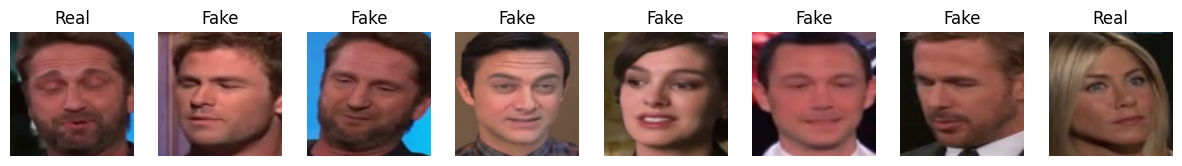

In [ ]:
import os
import zipfile
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
real_zip = "/content/drive/MyDrive/cropped_new-real.zip"
fake_zip = "/content/drive/MyDrive/cropped_new_fake.zip"
extract_dir = "/content/data_cropped"
os.makedirs(extract_dir, exist_ok=True)

real_folder = os.path.join(extract_dir, "real")
fake_folder = os.path.join(extract_dir, "fake")
os.makedirs(real_folder, exist_ok=True)
os.makedirs(fake_folder, exist_ok=True)
with zipfile.ZipFile(real_zip, 'r') as zip_ref:
    zip_ref.extractall(real_folder)
with zipfile.ZipFile(fake_zip, 'r') as zip_ref:
    zip_ref.extractall(fake_folder)

# ---------------------------
#  Dataset  OpenCV
# ---------------------------
class OpenCVDataset(Dataset):
    def __init__(self, folder_list, labels, transform=None):
        self.samples = []
        self.transform = transform
        for folder, label in zip(folder_list, labels):
            for f in os.listdir(folder):
                self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        if img is None:

            img = np.zeros((224,224,3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
])

# ---------------------------
# Dataset و DataLoader
# ---------------------------
dataset = OpenCVDataset([real_folder, fake_folder], labels=[0,1], transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"✅ Total images: {len(dataset)}")


# ---------------------------
def show_sample_from_loader(loader, n=8):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15,3))
    for i in range(min(n, len(images))):
        img = images[i].permute(1,2,0).numpy()
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Real" if labels[i]==0 else "Fake")
    plt.show()

show_sample_from_loader(loader, n=8)


In [ ]:
from sklearn.model_selection import train_test_split
import shutil

def split_dataset(src_folder, dest_base, label_name, test_size=0.3, val_size=0.5):
    os.makedirs(dest_base, exist_ok=True)
    files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]

    train_val, test = train_test_split(files, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size, random_state=42)

    for subset_name, subset_files in zip(["train","val","test"], [train,val,test]):
        subset_folder = os.path.join(dest_base, subset_name, label_name)
        os.makedirs(subset_folder, exist_ok=True)
        for f in subset_files:
            shutil.copy(os.path.join(src_folder,f), subset_folder)


base_data_dir = "/content/data_final"

# تقسيم كل فئة
split_dataset(real_folder, base_data_dir, "real")
split_dataset(fake_folder, base_data_dir, "fake")

print("Dataset is split into train / val / test")


✅ Dataset is split into train / val / test


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(os.path.join(base_data_dir,"train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_data_dir,"val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(base_data_dir,"test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 8957, Val: 8957, Test: 7678


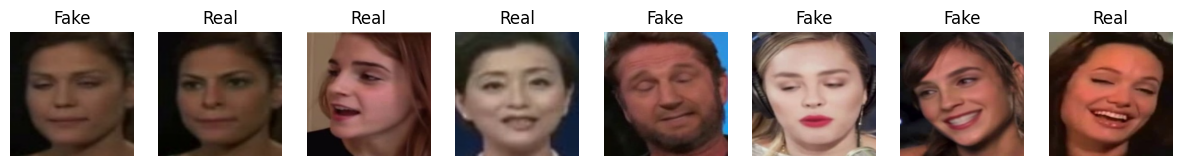

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import os
import numpy as np
from torchvision import transforms

class OpenCVDataset(Dataset):
    def __init__(self, folder, label, transform=None):
        self.samples = [(os.path.join(folder, f), label) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        if img is None:
            # صورة سوداء لو مش قادر يفتحها
            img = np.zeros((224,224,3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# ---------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

# ---------------------------
# إنشاء Datasets
# ---------------------------
train_real_folder = "/content/data_final/train/real"
train_fake_folder = "/content/data_final/train/fake"

train_dataset = OpenCVDataset(train_real_folder, 0, transform) + OpenCVDataset(train_fake_folder, 1, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# ---------------------------
import matplotlib.pyplot as plt

def show_sample_from_loader(loader, n=8):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15,3))
    for i in range(min(n, len(images))):
        img = images[i].permute(1,2,0).numpy()
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Real" if labels[i]==0 else "Fake")
    plt.show()

show_sample_from_loader(train_loader, n=8)
val_real_folder = "/content/data_final/val/real"
val_fake_folder = "/content/data_final/val/fake"

val_dataset = OpenCVDataset(val_real_folder, 0, transform) + OpenCVDataset(val_fake_folder, 1, transform)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_real_folder = "/content/data_final/test/real"
test_fake_folder = "/content/data_final/test/fake"

test_dataset = OpenCVDataset(test_real_folder, 0, transform) + OpenCVDataset(test_fake_folder, 1, transform)
test_loader   = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import timm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

model = timm.create_model('xception', pretrained=True, num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Training on: cuda


In [ ]:
num_epochs = 50
patience = 5  # للـ Early stopping
best_val_acc = 0
epochs_no_improve = 0

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    # ---------- Train ----------
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # ---------- Validation ----------
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
          f"Time: {epoch_time:.1f}s")

    # ---------- Early Stopping ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_xception_model.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


Epoch 1/50 - Train Loss: 0.1783, Train Acc: 0.9241, Val Loss: 0.0354, Val Acc: 0.9906, Time: 212.8s
Epoch 2/50 - Train Loss: 0.0257, Train Acc: 0.9929, Val Loss: 0.0177, Val Acc: 0.9935, Time: 205.2s
Epoch 3/50 - Train Loss: 0.0116, Train Acc: 0.9972, Val Loss: 0.0259, Val Acc: 0.9907, Time: 206.0s
Epoch 4/50 - Train Loss: 0.0120, Train Acc: 0.9962, Val Loss: 0.0241, Val Acc: 0.9916, Time: 209.1s
Epoch 5/50 - Train Loss: 0.0066, Train Acc: 0.9980, Val Loss: 0.0212, Val Acc: 0.9933, Time: 205.1s
Epoch 6/50 - Train Loss: 0.0047, Train Acc: 0.9985, Val Loss: 0.0243, Val Acc: 0.9918, Time: 204.5s
Epoch 7/50 - Train Loss: 0.0111, Train Acc: 0.9961, Val Loss: 0.0207, Val Acc: 0.9939, Time: 204.3s
Epoch 8/50 - Train Loss: 0.0042, Train Acc: 0.9987, Val Loss: 0.0234, Val Acc: 0.9924, Time: 204.5s
Epoch 9/50 - Train Loss: 0.0115, Train Acc: 0.9964, Val Loss: 0.0222, Val Acc: 0.9927, Time: 204.2s
Epoch 10/50 - Train Loss: 0.0039, Train Acc: 0.9990, Val Loss: 0.0173, Val Acc: 0.9941, Time: 204.4s

In [ ]:
#path to save on Drive
drive_model_path = "/content/drive/MyDrive/best_xception_model2911.pth"

# saving model on Drive
torch.save(model.state_dict(), drive_model_path)
print("Model saved to Drive at:", drive_model_path)


Model saved to Drive at: /content/drive/MyDrive/best_xception_model.pth


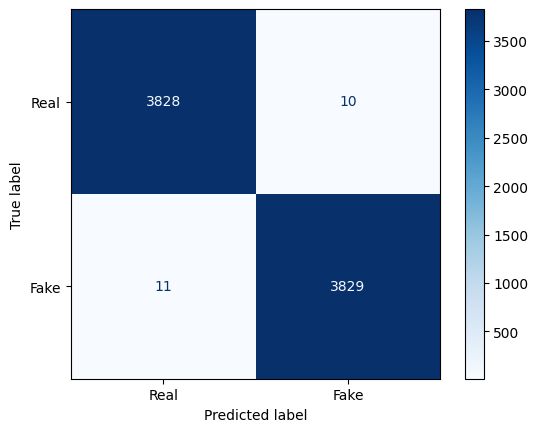

Test Accuracy: 0.9973


In [ ]:
# ===============================
# Evaluation & Confusion Matrix
# ===============================

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ----------Saving model ----------
best_model_path = "best_xception_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

# -------Test ----------
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---------- Confusion Matrix ----------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real","Fake"])


plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()

# ---------- Test ----------
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
print("Total train samples:", len(train_loader.dataset))
print("Total val samples:", len(val_loader.dataset))
print("Total test samples:", len(test_loader.dataset))


Total train samples: 8957
Total val samples: 8957
Total test samples: 7678


In [ ]:
# ===== خليّة 10: Fine-Tuning مع Early Stopping ووقت كل Epoch =====
# وظيفة الخلية: تدريب الموديل وعرض Loss, Accuracy, وقت كل Epoch مع Early Stopping

import time
import copy

num_epochs = 20           # أقصى عدد Epochs
patience = 3              # عدد Epochs بدون تحسن قبل إيقاف التدريب
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_acc, val_loss, val_acc = train_one_epoch(
        model, train_loader, val_loader, criterion, optimizer, device
    )

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {epoch_time:.2f}s")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⚠ Early stopping at epoch {epoch+1}")
            break

# استرجاع أفضل أوزان بعد Early Stopping
model.load_state_dict(best_model_wts)


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataset.py", line 399, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 229, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 268, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 247, in pil_loader
    img = Image.open(f)
          ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/PIL/Image.py", line 3283, in open
    if exclusive_fp:
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/content/data_celeb_cropped2911/raw/fake/id29_id35_0008_377.jpg'>


In [ ]:
# ===== خليّة 11: حفظ الموديل بعد Fine-Tuning =====
save_path = '/content/drive/MyDrive/model_v3_finetuned.pth'
torch.save(model.state_dict(), save_path)
print(f"✅ تم حفظ وزن الموديل في {save_path}")


In [ ]:
# ===== خليّة 12: رسم Confusion Matrix =====
# وظيفة الخلية: تقييم الموديل على Test Set ورسم Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Accuracy
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f" Test Accuracy: {accuracy:.4f}")
